# Python, Centrale Lille, G3 SDIA
---
## TP 5 : data visualization with seaborn, parallel Markov chains with multiprocessing and dask

---
## Guidelines (read carefully before starting)


**Objectives**: acquire further practice with a few parallelisation techniques in Python (`multiprocessing`).

**Guidelines**: after retrieving the resources for the lab on moodle:
- place the `.zip` archive in a local folder (Computer -> Documents/Python/);
- unzip the archive `.zip`;
- rename the folder with the convention `tp5_Name1_Name2`;
- duplicate the notebook file and rename it `tp5_Name1_Name2.ipynb`;
- [**optional, possibly needed if working from Centrale's machines**]
    - create a `tp5` conda environment from the provided `requirement.txt` file
    ```bash
    conda create --name=tp5 --file=requirement.txt
    conda activate tp5
    # do not forget to deactivate the environment if needed
    # you can remove the environment once you are done
    conda env remove --name=tp5
    ```
    - launch jupyter notebook (the python environment will be the one from the conda environment `tp5`)
- at the end of the session, do not forget to transfer your work to your own network space if you are working on a machine from the school (do not leave your work on the C: drive).

**Assessment** &#8594; global grade from F to A (A+)

This lab session will be evaluated, based on your answer to the exercises reported in a Jupyter notebook (e.g., this one) and any additional `.py` file produced. Any code produced should be commented whenever appropriate, custom functions and objects documented and unit-tested (see session 1). Figure produced should be clearly annotated (axis, title, legend whenever appropriate).

1. Numerical correctness
2. Implementation clarity (documentation, relevance of the comments)
3. Unit-tests developed whenever appropriate (correctness, relevance)
4. Answers to the questions and overall presentation of the Jupyter notebook.

**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

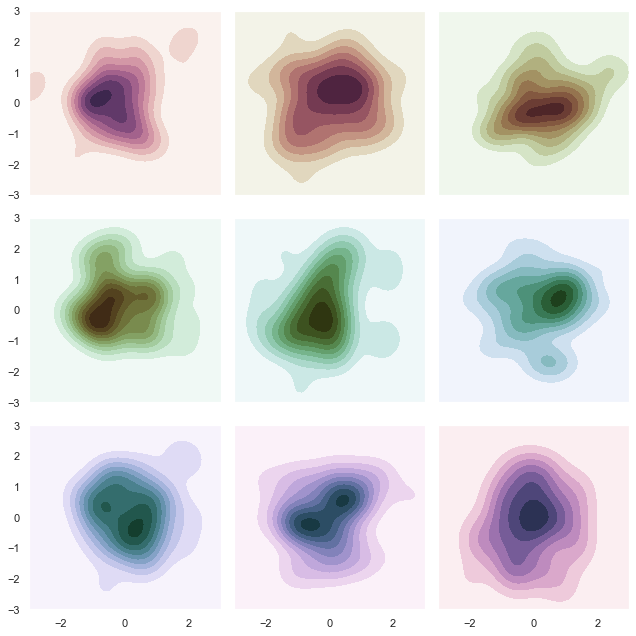

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="dark")
rng = np.random.default_rng(50) #set the seed so we got the same plot everytime we run this code

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True) #Slice the matplotlib figure into 3*3 subplots

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50)) #Create two lists of 50 random numbers following the normal distribution
    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax) #Plot level lines of the bivariate density
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()


1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method (take a look at the documentation and online).

In [3]:
# answer

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

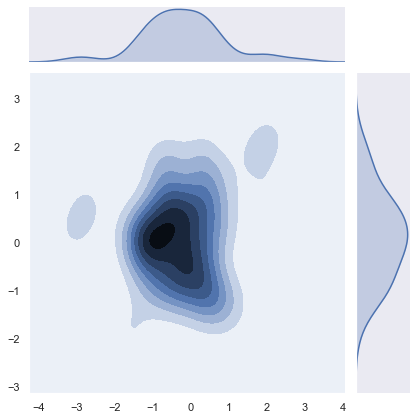

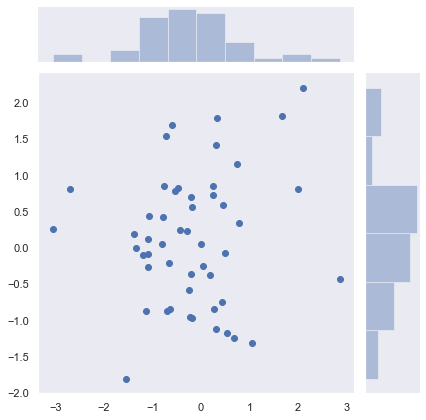

In [4]:
#Q2
sns.set(style="dark")
rng = np.random.default_rng(50) #set the seed so we got the same plot everytime we run this code

# Generate and plot a random bivariate dataset
x, y = rng.normal(size=(2, 50)) #Create two lists of 50 random numbers following the normal distribution

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    x=x, y=y,
    kind="kde",
)

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    x=x, y=y
)

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n+1} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$),
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).

> Hint: the function `np.random.choice` can be useful to draw discrete random variables.

In [5]:
#Q1
def markov(rho,A,nmax,rng):
    N = len(rho)
    X = []
    assert N == len(A[0])
    X.append(rng.choice(N, N, p=rho))
    for i in range(0,nmax-1):
        X.append(np.dot(X[i],A))
    return X

2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

[[1.         2.         2.        ]
 [2.4        2.3        0.3       ]
 [2.61       1.92       0.47      ]
 [2.344      2.203      0.453     ]
 [2.5421     2.0032     0.4547    ]
 [2.40224    2.14323    0.45453   ]
 [2.500261   2.045192   0.454547  ]
 [2.4316344  2.1138203  0.4545453 ]
 [2.47967421 2.06578032 0.45454547]
 [2.44604622 2.09940832 0.45454545]
 [2.46958583 2.07586872 0.45454545]
 [2.4531081  2.09234644 0.45454545]
 [2.46464251 2.08081204 0.45454545]
 [2.45656843 2.08888612 0.45454545]
 [2.46222028 2.08323426 0.45454545]]


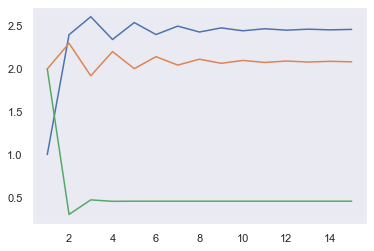

In [14]:
#Q2
from numpy.random import default_rng

rng = default_rng(11) #Set the random seed to 11
rho = [0.1,0.3,0.6]
A = [[0.2,0.7,0.1],
     [0.9,0.0,0.1],
     [0.2,0.8,0.0]]
nmax = 15

def markov_plot(rho,A,nmax,rng):
    X = markov(rho,A,nmax,rng)
    print(np.array(X))
    X = np.transpose(X)
    for i in range(3):
        plt.plot(np.arange(1,nmax+1),X[i])
    plt.show()
    
markov_plot(rho,A,nmax,rng)

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.star_map` or `mutiprocessing.Pool.starmap_async` methods could be useful.

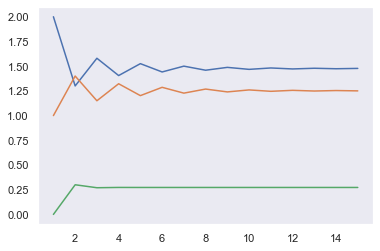

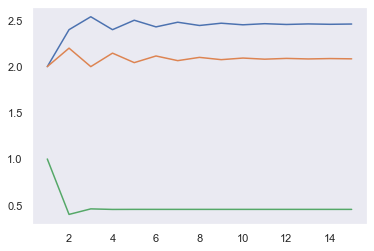

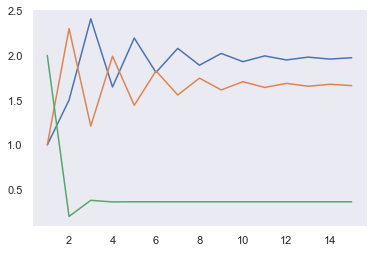

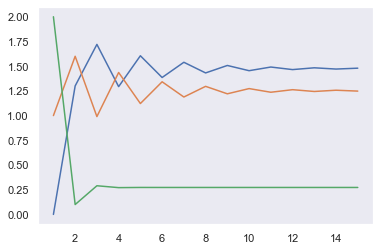

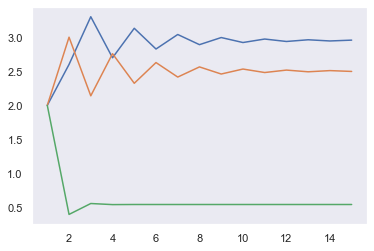

[None, None, None, None, None]


In [13]:
#Q3
n = 5
test_set = [default_rng(i) for i in range(n)]
test = map(markov_plot, [rho]*n, [A]*n, [nmax]*n, test_set)
print(list(test))

4. **[TO BE REMOVED IF NEEDED]** [Bonus] Take a look at the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of `Futures`). Note that this library is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

In [8]:
# answer

## [TO BE REMOVED IF NEEDED] <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/01_dask.delayed.html). Apply some of the concepts introduced herein to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation.

In [9]:
# answer